# Session 10: Coding Solution

```{contents}

```

In [ ]:
!pip install gymnasium

# Coding Practice

In this assignment, we will perform Planning for the game Frozen Lake. Unlike the lab, the game will be created automatically by OpenAI's `gymnasium` library and this is the Stochastic Environment (performing an `A` action will have a probability of reaching different `s` states)


In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt

In [ ]:
# intialize the environment
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")
env.reset() # use this to reset the environment to intial state

(0, {'prob': 1})

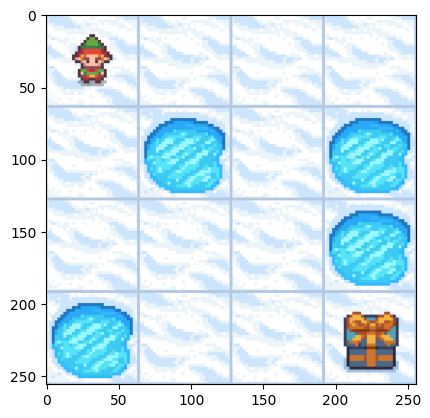

In [ ]:
# render game
frame = env.render()
plt.imshow(frame)
plt.show()

According to the documentation of the library [here](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

The game has 4 actions as follows:
- `0` Move left
- `1` Move down
- `2` Move right
- `3` Move up

Reward
- Reach goal: `+1`
- Reach hole: `0`
- Reach frozen: `0`

## Instructions for dealing with Environment

When calling the `reset` function, the game environment will be reset to its original state, the player will be in position `0`.

In [ ]:
state, info = env.reset()
print(state)
# info is a dictionary contains secondary information
# In this case the probability of resulting in state=0 is 100%
print(info)

0
{'prob': 1}


The `step(action)` function will return the following information:
- `next_state` index of the next state
- `Reward` reward of next state
- `terminated` Boolean indicates whether the game is over or not (falling into the hole, reaching the goal)
- `truncated` in this notebook we don`t use this value
- `info` dictionary contains probabilistic information to reach `next_state`

In [ ]:
next_state, reward, terminated, truncated, info = env.step(1)

Said earlier, this is the Stochastic Environment.

Running the cell below many times we observe that although performing Action=Right, the new position of the player can be in 1 of the following 3 cases:
- No change
- To the right
- Going down

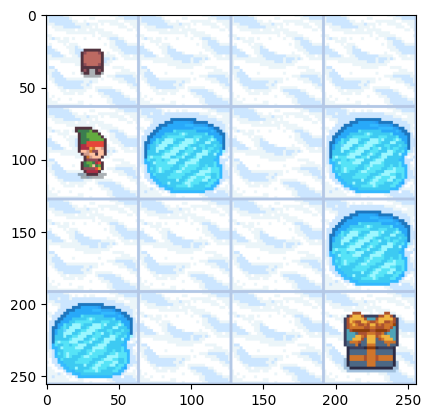

In [ ]:
# to reset the state of the game to original
env.reset()
# Perform action to the right
env.step(2)
# render
frame = env.render()
plt.imshow(frame)
plt.show()

In [ ]:
env.reset()
info = env.step(2)
info

(0, 0.0, False, False, {'prob': 0.3333333333333333})

We can get a complete description of the environment with the command `env.P`

Kết quả là 1 dictionary theo format sau
```python
{
  state_0: { # state index 0
    action_0: [ # list contains cases that occur when executing action_0
      # probability for next state to happen, next_state, reward, terminated (true or false)
      (prob_0, next_state_0, reward_0, terminated_0),
      (prob_1, next_state_1, reward_1, terminated_1),
      ...
    ]
    action_1: [ # similar to action_0, but for action_1
      (prob_0, next_state_0, reward_0, terminated_0),
      (prob_1, next_state_1, reward_1, terminated_1),
      ...
    ],
    ... # the rest of actions
  }
  state_1: {}, # similar to state_0, but for state_1
  ... # the rest of state
}
```
For example, we will take out all the possible cases when the agent is in State 9.

In [ ]:
env.P

In [ ]:
ACTION_LABELS = ["GO LEFT", "GO DOWN", "GO RIGHT", "GO UP"]
print("At State 9")
for k, v in env.P[9].items():
  # key là action
  # value là list chứa các trường hợp sẽ xảy khi thực hiện action
  print(f"If executing action: {ACTION_LABELS[k]}")
  for result in v:
    prob, next_state, reward, terminated = result
    print(f"Probability {prob} to get into {next_state} with reward={reward}, game over = {terminated}")
  print("="*30)

At State 9
If executing action: GO LEFT
Probability 0.3333333333333333 to get into 5 with reward=0.0, game over = True
Probability 0.3333333333333333 to get into 8 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 13 with reward=0.0, game over = False
If executing action: GO DOWN
Probability 0.3333333333333333 to get into 8 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 13 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 10 with reward=0.0, game over = False
If executing action: GO RIGHT
Probability 0.3333333333333333 to get into 13 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 10 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 5 with reward=0.0, game over = True
If executing action: GO UP
Probability 0.3333333333333333 to get into 10 with reward=0.0, game over = False
Probability 0.3333333333333333 to get into 5 with reward=0.0, game ove

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_attr('P')` that will search the reminding wrappers.
  logger.warn(


#### TODO 1

From the above tests, conclude how the game's slide feature works?

Once you understand how to play, try to think about what is the optimal way to solve this problem?



**Your answer here**

- In each state, we will take an action with the step(action) function and will receive the return values of next_state, reward, terminated, truncated, info. We will choose which action has the highest Q value
- Next, when we get the new state, we will update **Q(state,action)** with the formula **Bellman's Optimality Equations** (if current state is not terminated)

## Planning

In this section, we use Bellman's Optimality Equations to perform Planning for the glacial lake problem with the Stochastic Environment

**Bellman's Optimality Equations**

$$
\forall s,a: ~ Q(s,a) = \sum_{s'} P(s'|s,a)\big[R(s,a,s') + \gamma \max_{a'}(Q(s',a'))\big].
$$

- $\max(Q(s',a'))$: The max value of ``Q[next_state]``
- $P(s'|s,a)$: Probability of reaching the state $s'$ after executing action $a$ at state $s$  
- $R(s,a,s')$: reward received upon arrival in the state $s'$ from state $s$ with action $a$

#### TODO 2

Use Bellman Equations to complete the `planning` function below (similar to Lab, but with probability)

Note: if the current state is terminal, do not update


Hint: use loops to compute the sum $\sum$ `for probability, next_state, reward, _ in env.P[state][action]`

In [ ]:
import numpy as np
terminals = [5, 7, 11, 12, 15]

def planning(env, iters, terminals, gamma=0.9):
  num_state = env.observation_space.n
  num_action = env.action_space.n

  Q = np.zeros(shape=(num_state, num_action))

  for _ in range(iters):
    for state in range(Q.shape[0]):
      if state in terminals:
        continue
      for action in range(Q.shape[1]):
        temp = 0
        for probability, next_state, reward, _ in env.P[state][action]:
            temp += probability * (reward + 0.1 + gamma*np.max(Q[next_state]))
        Q[state, action] = temp
  return Q

In [ ]:
Q = planning(env, 1000, terminals)

In [ ]:
Q

array([[0.99803657, 0.99803657, 0.99803657, 1.        ],
       [0.7       , 0.7       , 0.7       , 1.        ],
       [0.90177244, 0.90177244, 0.90177244, 1.        ],
       [0.7       , 0.7       , 0.7       , 1.        ],
       [0.99345522, 0.69345522, 0.69541866, 0.69803657],
       [0.        , 0.        , 0.        , 0.        ],
       [0.67257479, 0.37257479, 0.67257479, 0.4       ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.69345522, 0.68669229, 0.6893102 , 0.98472885],
       [0.69833731, 0.9709121 , 0.67549345, 0.66799345],
       [0.90858263, 0.7068102 , 0.617309  , 0.59304607],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.69419229, 0.71845522, 1.00972885, 0.7068102 ],
       [0.99103001, 1.05178856, 1.02144469, 1.00882678],
       [0.        , 0.        , 0.        , 0.        ]])

#### TODO 3



From the `Q` matrix, complete the `get_optimal_actions` below.

This function returns `1 list` with the number of elements equal to the number of states, the numbers inside indicate the best action that the agent must perform when in the corresponding state based on the optimized `Q` matrix


In [ ]:
def get_optimal_actions(env, optimal_Q):
  optimal_actions = []

  current_state = 0
  for state in range(16):
    optimal_action = np.argmax(Q[state])
    optimal_actions.append(optimal_action)

  return optimal_actions

In [ ]:
optimal_actions = get_optimal_actions(env, Q)
print(optimal_actions)

[3, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0]


**Visualize policy tối ưu đã học được**

In [ ]:
import pandas as pd
from matplotlib.table import Table

def visualize_policy(optimal_actions, terminal):
  ACTION_LABELS = ["left", "down", "right", "up"]

  temp = []
  for i in range(4):
    temp_1 = []
    for j in range(4):
      temp_1.append(ACTION_LABELS[optimal_actions[i*4+j]])
    temp.append(temp_1)

  data = pd.DataFrame(temp)
  fig, ax = plt.subplots(figsize=(7,7))
  ax.set_axis_off()
  tb = Table(ax, bbox=[0,0,1,1])

  nrows, ncols = 4, 4
  width, height = 1.0 / ncols, 1.0 / nrows

  bkg_colors = ['teal' for i in range(16)]
  for pos in terminal:
    bkg_colors[pos] = 'blue'
  bkg_colors[0] = 'orange'
  bkg_colors[15] = 'green'

  # Add cells
  for (i,j), val in np.ndenumerate(data):
    # Index either the first or second item of bkg_colors based on
    # a checker board pattern
    color = bkg_colors[i*4 + j]
    if i*4+j in terminal and i*4+j!=15:
      tb.add_cell(i, j, width, height, text='die',
                  loc='center', facecolor=color)
    elif i*4+j==15:
      tb.add_cell(i, j, width, height, text='goal',
                  loc='center', facecolor=color)
    else:
      tb.add_cell(i, j, width, height, text=val,
                  loc='center', facecolor=color)

  ax.add_table(tb)
  plt.show()

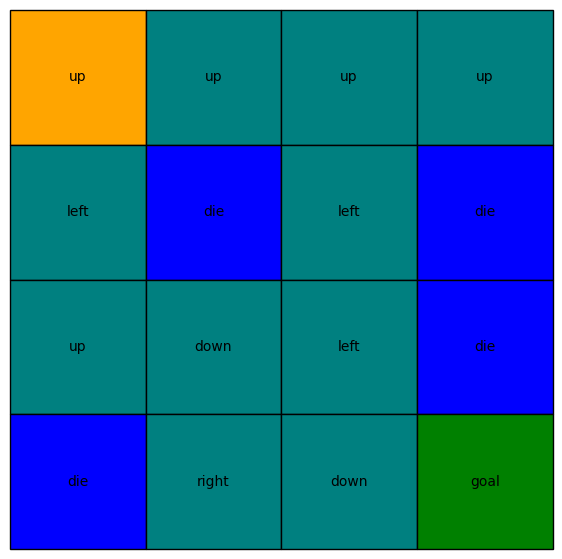

In [ ]:
visualize_policy(optimal_actions, terminal=[5, 7, 11, 12, 15])

Support function to compute winrate

In [ ]:
from tqdm.notebook import tqdm

def get_average_winrate(env, optimal_actions, num_play=10000):
  lost_count = 0
  step_count = 0
  for episode in tqdm(range(num_play)):
    state, info = env.reset()
    steps = 0
    while True:
      action = optimal_actions[state]
      state, reward, terminated, _, _ = env.step(action)
      steps += 1
      if terminated and reward == 1:
        # win
        step_count += steps
        break
      elif terminated and reward == 0:
        # lose
        lost_count += 1
        break
  print(f"{num_play} games")
  print("----------------------------------------------")
  print("You took an average of {:.2f} steps to reach goal".format(step_count / num_play))
  print("And you fell in the hole {} times ({:.2f}%)".format(lost_count, (lost_count/num_play) * 100))
  print("----------------------------------------------")

In [ ]:
get_average_winrate(env, optimal_actions)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Watch Agent plays

In [ ]:
def play_one_game(env, optimal_actions):
  frames = []
  cur_state, _ = env.reset()
  frames.append(env.render())
  while True:
    best_action = optimal_actions[cur_state]
    cur_state, _, terminated, _, _ = env.step(best_action)
    frames.append(env.render())
    if terminated:
      break
  return frames

In [ ]:
frames = play_one_game(env, optimal_actions)

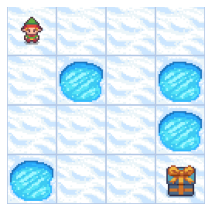

In [ ]:
import matplotlib.animation as anim
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = anim.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())